In [5]:
%pylab inline
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

import sys
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


In [6]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
save_path = 'cache/models'

In [20]:
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())
print(train_dataset.data.size())
print(test_dataset.data.size())







digit_p, digit_q =  4, 7

# digit_p, digit_q =  4,9


data1 = train_dataset
# selecting number 0 zero only
tt = data1.targets[(data1.targets== digit_p) | (data1.targets== digit_q)]
tt[tt==digit_p] =  0
tt[tt==digit_q] = 1
dd = data1.data[(data1.targets== digit_p) | (data1.targets== digit_q)] 
# tt = data.targets[(data.targets== 1)]
# dd = data.data[(data.targets== 1)] 

data1.targets = tt
data1.data = dd
train_loader = torch.utils.data.DataLoader(data1, batch_size=100, shuffle=True, drop_last = True)
# Num batches
# num_batches = len(train_loader)

print((tt==0).sum(), (tt==1).sum())





data2 = test_dataset
# selecting number 0 zero only
tt = data2.targets[(data2.targets== digit_p) | (data2.targets== digit_q)]
tt[tt==digit_p] =  0
tt[tt==digit_q] = 1
dd = data2.data[(data2.targets== digit_p) | (data2.targets== digit_q)] 
# tt = data.targets[(data.targets== 1)]
# dd = data.data[(data.targets== 1)] 

data2.targets = tt
data2.data = dd
test_loader = torch.utils.data.DataLoader(data2, batch_size=100, shuffle=True, drop_last = True)
# Num batches
# num_batches = len(train_loader)
print((tt==0).sum(), (tt==1).sum())














torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
tensor(5842) tensor(6265)
tensor(982) tensor(1028)


In [14]:
# train_dataset.data

In [21]:
p = train_dataset.data.size()[1]
num_cls = len(set(train_dataset.targets.numpy()))
print(p, num_cls)

batch_size = 100
n_iters = 10000
num_epochs = int(n_iters / (len(train_dataset) / batch_size))+1
print('number of epochs: {}'.format(num_epochs))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

28 2
number of epochs: 83


In [46]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your RNN
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='tanh')

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)

        # One time step
        # We need to detach the hidden state to prevent exploding/vanishing gradients
        # This is part of truncated backpropagation through time (BPTT)
        out, hn = self.rnn(x, h0.detach())

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

input_dim = 4
hidden_dim = 2
layer_dim = 2  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
output_dim = 10

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)
model.to(device)

# JUST PRINTING MODEL & PARAMETERS 
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

RNNModel(
  (rnn): RNN(4, 2, num_layers=2, batch_first=True)
  (fc): Linear(in_features=2, out_features=10, bias=True)
)
10
torch.Size([2, 4])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2])
torch.Size([10, 2])
torch.Size([10])


In [51]:
### Model Training
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

# Number of steps to unroll
seq_dim = 28*28 // 4 

iter = 0
best_acc = 0
num_epochs = 6
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        model.train()
        # Load images as tensors with gradient accumulation abilities
        images, labels = images.view(-1, seq_dim, 
                                     input_dim).requires_grad_().to(device), labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            model.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            with torch.no_grad():
                # Iterate through test dataset
                for images, labels in test_loader:
                    # Resize images
                    images = images.view(-1, seq_dim, input_dim).to(device)

                    # Forward pass only to get logits/output
#                     import pdb; pdb.set_trace()
                    outputs = model(images)

                    # Get predictions from the maximum value
                    _, predicted = torch.max(outputs.data, 1)

                    # Total number of labels
                    total += labels.size(0)

                    # Total correct predictions
                    if cuda:
                        correct += (predicted.cpu() == labels.cpu()).sum()
                    else:
                        correct += (predicted == labels).sum()

            accuracy = 100 * correct.float() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
            if accuracy > best_acc:
                best_acc = accuracy
                torch.save({'epoch': epoch,
                            'model': model.state_dict(),
                            'optimizer': optimizer.state_dict()
                           }, '{}/rnn_iter_{}.pth'.format(save_path, iter))
                print('\r Best model saved.\r')
      

Iteration: 500. Loss: 0.7144721746444702. Accuracy: 51.14427947998047
 Best model saved.
Iteration: 1000. Loss: 0.7127699255943298. Accuracy: 51.14427947998047
Iteration: 1500. Loss: 0.6995964646339417. Accuracy: 51.14427947998047
Iteration: 2000. Loss: 0.7078530192375183. Accuracy: 51.14427947998047
Iteration: 2500. Loss: 0.7059417963027954. Accuracy: 51.14427947998047
Iteration: 3000. Loss: 0.7016143798828125. Accuracy: 51.14427947998047


In [7]:
### Load and use the best model
bst_mdl = save_path+'/rnn_best.pth'
model.load_state_dict(torch.load(bst_mdl)['model'])

<All keys matched successfully>

In [32]:
images.shape

torch.Size([100, 1, 28, 28])

In [16]:
# import torch 
# import torch.nn as nn
# import torchvision
# import torchvision.transforms as transforms


# # Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Hyper-parameters
# sequence_length = 28
# input_size = 28
# hidden_size = 128
# num_layers = 2
# num_classes = 10
# batch_size = 100
# num_epochs = 5
# learning_rate = 0.01


# # Recurrent neural network (many-to-one)
# class RNN(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super(RNN, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, num_classes)
    
#     def forward(self, x):
#         # Set initial hidden and cell states 
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
#         # Forward propagate LSTM
#         out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
#         # Decode the hidden state of the last time step
#         out = self.fc(out[:, -1, :])
#         return out

# model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)


# # Loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# # Train the model
# total_step = len(train_loader)
# for epoch in range(num_epochs):
#     for i, (images, labels) in enumerate(train_loader):
#         images = images.reshape(-1, sequence_length, input_size).to(device)
#         labels = labels.to(device)
        
#         # Forward pass
#         outputs = model(images)
#         loss = criterion(outputs, labels)
        
#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         if (i+1) % 100 == 0:
#             print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
#                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# # Test the model
# with torch.no_grad():
#     correct = 0
#     total = 0
#     for images, labels in test_loader:
#         images = images.reshape(-1, sequence_length, input_size).to(device)
#         labels = labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 

# # Save the model checkpoint
# torch.save(model.state_dict(), 'model.ckpt')

Epoch [1/5], Step [100/600], Loss: 0.4816
Epoch [1/5], Step [200/600], Loss: 0.2950
Epoch [1/5], Step [300/600], Loss: 0.2927
Epoch [1/5], Step [400/600], Loss: 0.1200
Epoch [1/5], Step [500/600], Loss: 0.1486
Epoch [1/5], Step [600/600], Loss: 0.0772
Epoch [2/5], Step [100/600], Loss: 0.0325
Epoch [2/5], Step [200/600], Loss: 0.1791
Epoch [2/5], Step [300/600], Loss: 0.1668
Epoch [2/5], Step [400/600], Loss: 0.2146
Epoch [2/5], Step [500/600], Loss: 0.0146
Epoch [2/5], Step [600/600], Loss: 0.0834
Epoch [3/5], Step [100/600], Loss: 0.0175
Epoch [3/5], Step [200/600], Loss: 0.0621
Epoch [3/5], Step [300/600], Loss: 0.1029
Epoch [3/5], Step [400/600], Loss: 0.0541
Epoch [3/5], Step [500/600], Loss: 0.1015
Epoch [3/5], Step [600/600], Loss: 0.0447
Epoch [4/5], Step [100/600], Loss: 0.0538
Epoch [4/5], Step [200/600], Loss: 0.2240
Epoch [4/5], Step [300/600], Loss: 0.1090
Epoch [4/5], Step [400/600], Loss: 0.0375
Epoch [4/5], Step [500/600], Loss: 0.0854
Epoch [4/5], Step [600/600], Loss:

In [25]:
### Feeding white-noise
model.eval()

batch_size = 10000
all_size = 100000
iters = 100
stats = {} # recording the bias
noise = {}

for i in range(num_cls):
    stats[i] = 0
    noise[i] = []

with tqdm(total=iters, file=sys.stdout) as pbar:
    for kk in range(iters):
        z = torch.rand(all_size, p, p)
        for k in range(0, all_size, batch_size):
            with torch.no_grad():
                cur_data = z[k:k+batch_size]
                if cuda:
                    cur_data = cur_data.cuda()
                pred = model(cur_data).max(1)[1]

            for i in range(num_cls):
                noise[i].append(cur_data[pred == i].cpu())
                stats[i] += (pred == i).sum().cpu()
        pbar.update(1)

100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


In [26]:
stats

{0: tensor(3190130), 1: tensor(6809870)}

In [15]:
pred

tensor([9, 8, 9,  ..., 8, 8, 8], device='cuda:0')

0


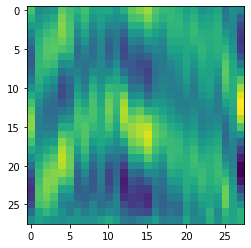

1


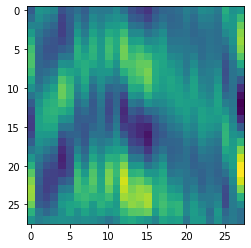

In [27]:
# visualize
for i in range(num_cls):
    if stats[i] != 0:
        print(i)
        plt.imshow(torch.cat(noise[i]).mean(0))
        plt.show()